# Email Attachment Detector

By: Marius Barcenas, Julia Dy, Joshua Felipe

This CS 180 (Artificial Intelligence) project aims to develop an AI model that determines whether an email should include an attachment based on its text content. It will be trained to analyze the purpose of the email and identify keywords or phrases that suggest the presence of an attachment. This project used the researchers’ personal and marketing emails as their dataset.

# Installing and Importing Relevant Libraries

In [1]:
pip install html2text pandas cleantext nltk demoji joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing the libraries to be used
import html2text as h
import pandas as pd
import cleantext
import demoji
import re
from joblib import dump, load

# Constant filenames
ORIG_FILE = "emails_rows.csv"
NEW_FILE = f"modified_{ORIG_FILE}"

# Data Collection and Preprocessing

Gmail emails of the researchers were scraped using a Google API, and were saved to a Supabase project for tagging and data cleaning.

The researchers manually tagged the data based on whether or not they should have an attachment through a personalized web application.

Emails were stripped to their bare content. Specifically, email tags, emojis, extraneous whitespaces, links, punctuations, and email signatures were removed using the html2text, demoji and cleantext libraries.

Data contains the following labels ('id', 'created_at', 'email', 'email_timestamp', 'content', 'tag', 'valid', 'tag_timestamp', 'from', 'subject', 'tagger'). Only the content and tag are relevant for this project.

In [3]:
def removeExtraCharacters(s):
    # Uses cleantext library to remove extra characters, lowecase all text, and remove stopwords
    return cleantext.clean(s, lowercase=True, punct=True, extra_spaces=True, stopwords=True, stp_lang='english')

def cleanString(s):
    # Uses demoji library to remove any emojis in the email.
    return demoji.replace(removeExtraCharacters(s), '')

def removeReplies(s):
    # Removes any replies in the email.
    return re.sub(r'<[^<]*class=\"gmail_quote\"[\s\S]*$', '', s)

### Important

Before running the preprocessing code, download the nltk stopwords here: https://www.nltk.org/nltk_data/

Extract and put the stop words to the nltk_data folder in your home directory.

In my case: /User/\<NAME\>/nltk_data/corpora

In [4]:
# PREPROCESSING

# Load the data
data = pd.read_csv(ORIG_FILE)

# Data Cleaning
data = data.dropna()                                # Drop rows with missing data
data.tag = data.tag.replace({True: 1, False: 0})    # Convert boolean tags to 1 and 0
data["content"] = data["content"].apply(lambda x: removeReplies(x))
data["content"] = data["content"].apply(lambda x: cleanString(h.html2text(x)))

# Save the data to NEW_FILE
data.to_csv(NEW_FILE, index=False)


In [5]:
# IMPORTING THE MODIFIED DATA
data = pd.read_csv(NEW_FILE)
data.columns

Index(['id', 'created_at', 'email', 'email_timestamp', 'content', 'tag',
       'valid', 'tag_timestamp', 'from', 'subject', 'tagger'],
      dtype='object')

# Setting up the Training and Testing Data

All of the words were changed into lowercase letters and tokenised and vectorised using TfidfVectorizer() from the sklearn library. In addition, the researchers removed stopwords using the same library.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Using the TfidfVectorizer to convert the text data into a matrix of TF-IDF features
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')

# Splitting the data into training and testing data
x = tfidf.fit_transform(data["content"].values.astype('U'))
y = data["tag"].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=16)

print(data.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1557, 11)
(934, 44824)
(623, 44824)
(934,)
(623,)


# Printing and Saving the Model's Results

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, square = True, annot = True, cbar = False)
    plt.xlabel('predicted value')
    plt.ylabel('true value')

def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: %.2f' % accuracy)
    print('precision: %.2f' % precision_score(y_test, y_pred,average='weighted'))
    print('recall: %.2f' % recall_score(y_test, y_pred,average='weighted'))
    print('f1_score: %.2f' % f1_score(y_test, y_pred,average='weighted'))

def save_and_load_model(model, filename):
    dump(model, filename)
    return load(open(filename, 'rb'))

# Training the Model

The researchers implemented and compared the performance of three different machine learning models: Naive Bayes, Logistic Regression, and Support Vector Machines (SVM). Each model was trained on the preprocessed dataset described above, and their performances were evaluated based on accuracy, precision, F1 score, and recall.

## Naive Bayes Classfier

Naive Bayes is computationally efficient, making it a good baseline model. It handles high-dimensional textual content statistics by assuming function independence. Moreover, it gives probabilistic outputs that provide insights into its predictions.

accuracy: 0.90
precision: 0.90
recall: 0.90
f1_score: 0.90
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       452
           1       0.93      0.69      0.79       171

    accuracy                           0.90       623
   macro avg       0.91      0.84      0.86       623
weighted avg       0.90      0.90      0.90       623



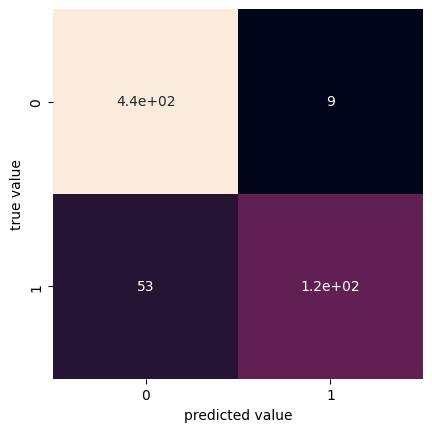

In [8]:
# NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB().fit(x_train, y_train)            # Initializing an instance for Naive Bayes Classifier and Training the model
load_model = save_and_load_model(nb_model, 'nb_model.pkl')  # Saving and loading the model
y_pred = load_model.predict(x_test)                         # Predicting the test data

# Printing the scores and report
print_scores(y_test, y_pred)
print_report(y_test, y_pred)

## Logistic Regression
Logistic Regression is highly interpretable, offering clear insights into words or phrases that are most influential in predicting the need for an attachment. It scales well with large datasets, essential for processing extensive email data.

accuracy: 0.91
precision: 0.91
recall: 0.91
f1_score: 0.90
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       452
           1       0.96      0.69      0.80       171

    accuracy                           0.91       623
   macro avg       0.93      0.84      0.87       623
weighted avg       0.91      0.91      0.90       623



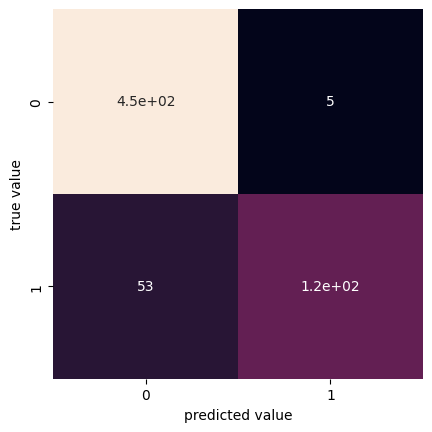

In [9]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(x_train, y_train)             # Initializing an instance for Logistic Regression and Training the model
load_model = save_and_load_model(logreg, 'logreg_model.pkl')    # Saving and loading the model
y_pred = load_model.predict(x_test)                             # Predicting the test data

# Printing the scores and report
print_scores(y_test, y_pred)
print_report(y_test, y_pred)

## Suppport Vector Machine
SVM handles high-dimensional spaces effectively, which is advantageous for text data represented through TF-IDF. It maximizes the margin between classes, often resulting in better generalization on unseen data. 

accuracy: 0.91
precision: 0.92
recall: 0.91
f1_score: 0.91
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       452
           1       0.95      0.73      0.83       171

    accuracy                           0.91       623
   macro avg       0.93      0.86      0.88       623
weighted avg       0.92      0.91      0.91       623



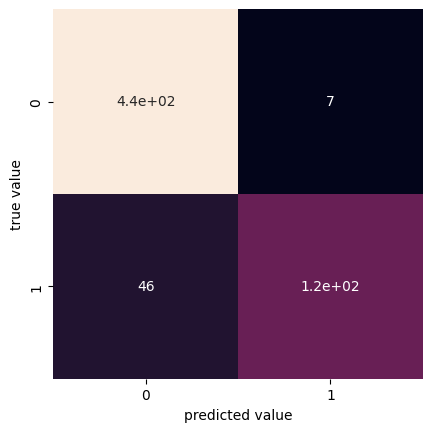

In [10]:
# SUPPORT VECTOR MACHINE
from sklearn import svm

svmsvc = svm.SVC().fit(x_train, y_train)                        # Initializing an instance for Support Vector Machine and Training the model
load_model = save_and_load_model(svmsvc, 'svmsvc_model.pkl')    # Saving and loading the model
y_pred = load_model.predict(x_test)                             # Predicting the test data

# Printing the scores and report
print_scores(y_test, y_pred)
print_report(y_test, y_pred)

# Data Analysis

Among the three models used, the Support Vector Machine (SVM) model had the best results. It had the highest score across all four performance metrics (accuracy, precision, recall, and F1-score). 
We can also see from the confusion matrices that the SVM model had the least false negatives (46, compared to 53 for the other two models). This is important because the purpose of our research is to create a model that can predict whether an email should include an attachment and decrease the risk of sending emails without attachments. For this purpose, it is best to minimize false negatives.
To summarize, the SVM model is chosen because it had the best performance among all three models used.

# References

GeeksforGeeks. (2020, August 25). Advantages and Disadvantages of Logistic Regression. GeeksforGeeks; GeeksforGeeks. https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/ 

What Are Naïve Bayes Classifiers? | IBM. (2021, October 6). Ibm.com. https://www.ibm.com/topics/naive-bayes#:~:text=Scales%20well%3A%20Compared%20to%20logistic,also%20has%20low%20storage%20requirements.

What Is Support Vector Machine? | IBM. (2023, December 12). Ibm.com. https://www.ibm.com/topics/support-vector-machine 
